######Dataset: https://www.kaggle.com/fizzbuzz/cleaned-toxic-comments

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
from __future__ import print_function, division
from builtins import range

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten

In [ ]:
os.getcwd()

'/content'

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

In [ ]:
#Load GloVe 50 d
word2vec = {}
f = open('/content/drive/My Drive/glove.6B.50d.txt',"r", errors = "ignore",encoding='utf8')
#First word of every line is the wrod and subsequent numbers are vectors corresponding to the first word
for line in f:
  values = line.split(' ')
  word = values[0]
  vec = np.asarray(values[1:], dtype=np.float32)
  word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [ ]:
#Preparing train and test data
train = pd.read_csv('/content/drive/My Drive/train_preprocessed.csv')
sents = train['comment_text'].fillna("dummy").values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target = train[labels].values

In [ ]:
#Convert sents to int
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(sents)
sequences = tokenizer.texts_to_sequences(sents)

In [ ]:
#Word to index
wordtoid = tokenizer.word_index
print(len(wordtoid))

166929


In [ ]:
#Add padding to sequences to get equal length matrix
data = pad_sequences(sequences, maxlen = 50)
print(data.shape)

(159571, 50)


In [ ]:
#Input for embedding layer
num_words = min(MAX_VOCAB_SIZE, len(wordtoid) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in wordtoid.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector #Words not present in embedding vectors will be zeros 


In [ ]:
print(len(embedding_matrix))

20000


In [ ]:
#Load pretrained to embedding layer
embedding_layer = Embedding(num_words, 50, weights = [embedding_matrix], input_length=100, trainable = False)

In [ ]:
#Train model
input_std = Input(shape = (MAX_SEQUENCE_LENGTH, ))
X = Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH)(input_std)
X = Conv1D(128,3, activation='relu')(X)
X = MaxPooling1D(3)(X)
X = Conv1D(128,3, activation='relu')(X)
X = MaxPooling1D(3)(X)
X = Conv1D(128,3, activation='relu')(X)
X = GlobalMaxPooling1D()(X)
X = Dense(128, activation='relu')(X)
output = Dense(len(labels), activation= 'sigmoid')(X)

model1 = Model(inputs = input_std, outputs = output)

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 128)           49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            49280 

In [ ]:
#Compile the model
from tensorflow.keras.optimizers import RMSprop
model1.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr=0.00001), metrics = ['accuracy'])

In [ ]:
#Training model
hist1 = model1.fit(data, target, epochs = 40, batch_size=128, validation_split=0.2)

Epoch 1/40
998/998 [==============================] - 27s 27ms/step - loss: 0.0221 - accuracy: 0.9687 - val_loss: 1.1376 - val_accuracy: 0.9191
Epoch 2/40
998/998 [==============================] - 25s 25ms/step - loss: 0.0220 - accuracy: 0.9714 - val_loss: 1.1235 - val_accuracy: 0.9152
Epoch 3/40
998/998 [==============================] - 25s 26ms/step - loss: 0.0219 - accuracy: 0.9715 - val_loss: 1.1452 - val_accuracy: 0.9192
Epoch 4/40
998/998 [==============================] - 24s 24ms/step - loss: 0.0219 - accuracy: 0.9721 - val_loss: 1.1225 - val_accuracy: 0.9139
Epoch 5/40
998/998 [==============================] - 24s 24ms/step - loss: 0.0219 - accuracy: 0.9717 - val_loss: 1.1521 - val_accuracy: 0.9206
Epoch 6/40
998/998 [==============================] - 24s 24ms/step - loss: 0.0219 - accuracy: 0.9733 - val_loss: 1.1521 - val_accuracy: 0.9214
Epoch 7/40
998/998 [==============================] - 24s 24ms/step - loss: 0.0219 - accuracy: 0.9724 - val_loss: 1.1647 - val_accuracy:

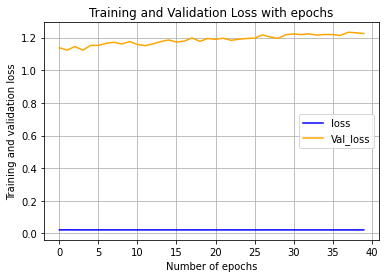

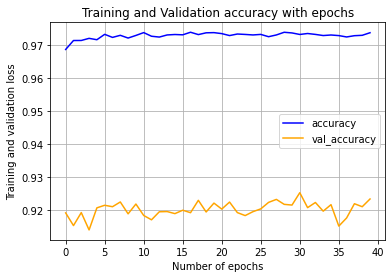

In [ ]:
#Plotting loss and accuracy
plt.plot(hist1.history['loss'], label = 'loss', color = 'blue')
plt.plot(hist1.history['val_loss'], label = 'Val_loss', color = 'orange')
plt.grid(True)
plt.title("Training and Validation Loss with epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Training and validation loss")
plt.legend()
plt.show()

plt.plot(hist1.history['accuracy'], label = 'accuracy', color = 'blue')
plt.plot(hist1.history['val_accuracy'], label = 'val_accuracy', color = 'orange')
plt.grid(True)
plt.title("Training and Validation accuracy with epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
input_std = Input(shape = (MAX_SEQUENCE_LENGTH, ))
X = Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH)(input_std)
X = LSTM(50, dropout = 0.2)(X)
output_X = Dense(len(labels), activation='sigmoid')(X)
model2 = Model(inputs = input_std, outputs = output_X)


In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                35800     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,596,106
Trainable params: 2,596,106
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import RMSprop
model2.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr=0.00001), metrics = ['accuracy'])
#model2.compile(optimizer= RMSprop(lr=0.0001), loss = binary_crossentropy, metrics = ['accuracy'])

In [ ]:
hist2 = model2.fit(data, target, epochs=40, batch_size=128, validation_split=0.2, verbose=2)

Epoch 1/40
998/998 - 27s - loss: 0.6485 - accuracy: 0.3196 - val_loss: 0.5331 - val_accuracy: 0.0762
Epoch 2/40
998/998 - 27s - loss: 0.3109 - accuracy: 0.0091 - val_loss: 0.2095 - val_accuracy: 0.0034
Epoch 3/40
998/998 - 27s - loss: 0.1808 - accuracy: 0.8224 - val_loss: 0.1609 - val_accuracy: 0.9941
Epoch 4/40
998/998 - 27s - loss: 0.1517 - accuracy: 0.9942 - val_loss: 0.1451 - val_accuracy: 0.9941
Epoch 5/40
998/998 - 26s - loss: 0.1426 - accuracy: 0.9942 - val_loss: 0.1407 - val_accuracy: 0.9941
Epoch 6/40
998/998 - 29s - loss: 0.1398 - accuracy: 0.9941 - val_loss: 0.1387 - val_accuracy: 0.9941
Epoch 7/40
998/998 - 28s - loss: 0.1372 - accuracy: 0.9941 - val_loss: 0.1351 - val_accuracy: 0.9941
Epoch 8/40
998/998 - 27s - loss: 0.1311 - accuracy: 0.9940 - val_loss: 0.1253 - val_accuracy: 0.9940
Epoch 9/40
998/998 - 27s - loss: 0.1179 - accuracy: 0.9854 - val_loss: 0.1097 - val_accuracy: 0.9563
Epoch 10/40
998/998 - 27s - loss: 0.1020 - accuracy: 0.9498 - val_loss: 0.0960 - val_accura

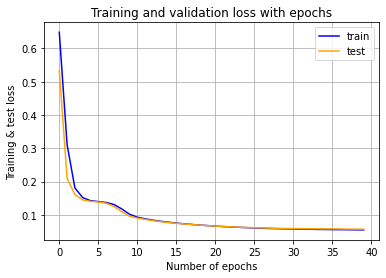

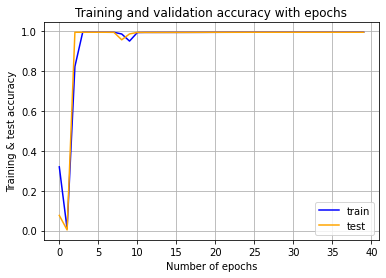

In [ ]:
#Plot the accuracy metrics
plt.plot(hist2.history['loss'], color = 'blue', label = 'train')
plt.plot(hist2.history['val_loss'], color = 'orange', label = 'test')
plt.title("Training and validation loss with epochs")
plt.ylabel("Training & test loss")
plt.xlabel("Number of epochs")
plt.grid()
plt.legend()
plt.show()

plt.plot(hist2.history['accuracy'], color = 'blue', label = 'train')
plt.plot(hist2.history['val_accuracy'], color = 'orange', label = 'test')
plt.title("Training and validation accuracy with epochs")
plt.ylabel("Training & test accuracy")
plt.xlabel("Number of epochs")
plt.grid()
plt.legend()
plt.show()


In [ ]:
sents_test = pd.read_csv("/content/drive/My Drive/test_preprocessed.csv")

In [ ]:
#Tokenizing
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(sents_test)
sequences_test = tokenizer.texts_to_sequences(sents_test)

#Word to index
wordtoid = tokenizer.word_index

#Add padding to sequences to get equal length matrix
test_data = pad_sequences(sequences, maxlen = 50)

In [ ]:
test_accuracy = test_metrics[1]
test_loss = test_metrics[0]
print(test_accuracy)
print(test_loss)

[0.00492887 0.00012626 0.0012011  0.00027134 0.00145747 0.00068878]
[0.00465276 0.00014092 0.00128774 0.00035691 0.00145186 0.00077605]


In [ ]:
####Looks like the model with lr 0.00001 is overfitting.